## Data Preprocess

In [1]:
import gzip
import json
import pickle
import pandas as pd
from typing import Generator, Dict, Any
from typing import List, Tuple, Optional, Union
from datetime import datetime


def year_to_timestamp_ms(year: int) -> int:
    dt = datetime(year, 1, 1)
    timestamp_ms = int(dt.timestamp() * 1000)
    return timestamp_ms


def parse(path: str) -> Generator[Dict[str, Any], None, None]:
    """Parse a gzip file containing JSON lines."""
    with gzip.open(path, "rt", encoding="utf-8") as f:
        for line in f:
            yield json.loads(line)

In [ ]:
raw_review_file = "./raw/Electronics.jsonl.gz"
raw_item_file = "./raw/meta_Electronics.jsonl.gz"
filtered_time_st = year_to_timestamp_ms(2019)

review_dict = {
    "user_id": [],
    "item_id": [],
    "timestamp": [],
    "click": [],
}
for l in parse(raw_review_file):
    try:
        if l["timestamp"] < filtered_time_st:
            continue
        click = 1 if l["rating"] >= 4 else 0
        review_dict["user_id"].append(l["user_id"])
        review_dict["item_id"].append(l["parent_asin"])
        review_dict["timestamp"].append(l["timestamp"])
        review_dict["click"].append(click)
    except KeyError:
        # Skip if the required keys are not present
        continue

review_df = pd.DataFrame.from_dict(review_dict)

In [17]:
review_df.describe()

,timestamp,click
count,2.257399e+07,2.257399e+07
mean,1.613943e+12,7.498483e-01
std,3.894661e+10,4.331002e-01
min,1.546272e+12,0.000000e+00
25%,1.580159e+12,0.000000e+00
50%,1.612133e+12,1.000000e+00
75%,1.646262e+12,1.000000e+00
max,1.694626e+12,1.000000e+00


In [31]:
review_df.head()

,user_id,item_id,timestamp,click
0,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,B083NRGZMM,1658185117948,0
1,AFKZENTNBQ7A7V7UXW5JJI6UGRYQ,B07N69T6TM,1592678549731,0
2,AG2L7H23R5LLKDKLBEF2Q3L2MVDA,B07CJYMRWM,1676601581238,1
3,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B07CML419K,1637522881041,1
4,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B07BHHB5RH,1565130879386,1


In [32]:
review_df.to_parquet(
    "./review/review.parquet",
    engine="pyarrow",
    index=False,
    compression="snappy",
)

In [5]:
review_df = pd.read_parquet("./review/review.parquet")

In [6]:
item_id_set = set(review_df["item_id"].unique())

In [41]:
item_info = {}
for l in parse(raw_item_file):
    asin = l.pop("parent_asin")
    if asin not in item_id_set:
        continue
    category = l.get("categories", [])
    use_l = {
        "average_rating": l.get("average_rating"),
        "rating_number": l.get("rating_number"),
    }
    if l.get("main_category", None):
        use_l["category"] = l["main_category"]
    else:
        use_l["category"] = category[1] if len(category) > 1 else "Electronics"
    item_info[asin] = use_l

In [42]:
category_set = set()
cnt = 0
for asin, item in item_info.items():
    category_set.add(item["category"])

In [43]:
len(category_set)

81

In [45]:
with open("./item/item_info.pkl", "wb") as f:
    pickle.dump(item_info, f)

In [4]:
with open("./item/item_info.pkl", "rb") as f:
    item_info = pickle.load(f)

## Statistic Analysis

In [5]:
user_id_set = set(review_df["user_id"].unique())

In [6]:
print(f"Item Size: {len(item_info)}")
print(f"User Size: {len(user_id_set)}")

Item Size: 1012470
User Size: 11944265


In [39]:
# plot the click distribution
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

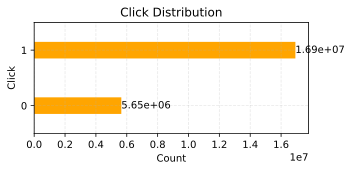

In [ ]:
click_dist = review_df.groupby("click").size()

plt.figure(figsize=(5, 2.5))  # Swapped figsize dimensions
bars = plt.barh(
    [0, 1], click_dist.values, color="orange", height=0.3
)  # Using barh instead of bar, and height instead of width
plt.ylabel("Click")  # Swapped xlabel to ylabel
plt.xlabel("Count")  # Swapped ylabel to xlabel

plt.title("Click Distribution")
plt.yticks([0, 1])  # Using yticks instead of xticks
plt.grid(True, linestyle="--", alpha=0.3)

for bar in bars:
    width = bar.get_width()  # Using width instead of height
    plt.text(
        width, bar.get_y() + bar.get_height() / 2.0, f"{width:.2e}", ha="left", va="center"
    )  # Adjusted text position and alignment

plt.ylim(-0.5, 1.5)  # Using ylim instead of xlim

plt.tight_layout()
plt.show()

## UID Vocab

In [46]:
from vocab import UIDVocab

In [ ]:
user_vocab = UIDVocab(list(user_id_set))
item_vocab = UIDVocab(list(item_id_set))

In [47]:
category_vocab = UIDVocab(list(category_set))

In [9]:
user_vocab.pad, user_vocab.unk

(0, 1)

In [10]:
user_vocab.save("./statistic/user_vocab.json", method="json")
item_vocab.save("./statistic/item_vocab.json", method="json")

In [48]:
category_vocab.save("./statistic/category_vocab.json", method="json")

In [ ]:
user_vocab = UIDVocab.load("./statistic/user_vocab.json")
item_vocab = UIDVocab.load("./statistic/item_vocab.json")

## Load Train && Test Dataset

In [1]:
import gzip
import json
import pickle
import pandas as pd
from typing import Generator, Dict, Any
from typing import List, Tuple, Optional, Union
from datetime import datetime
from vocab import UIDVocab

In [12]:
item_info = pickle.load(open("./item/item_info.pkl", "rb"))

In [ ]:
item_info["B01M0LGHN1"]

{'average_rating': 4.5, 'rating_number': 277, 'price': 12.99}

In [2]:
user_vocab = UIDVocab.load("./statistic/user_vocab.pkl")
item_vocab = UIDVocab.load("./statistic/item_vocab.pkl")
user_id_list = list(user_vocab.uid_to_idx.keys())[1:]

In [3]:
len(user_vocab), len(item_vocab), len(user_id_list)

(11944266, 1012471, 11944265)

In [4]:
train_data_file = "./train/train_data.txt"
test_data_file = "./test/test_data.txt"

with open(train_data_file, "r") as f:
    train_data = f.readlines()

with open(test_data_file, "r") as f:
    test_data = f.readlines()

In [ ]:
train_data[0].strip().split("\t")

['AE22242RL22PTPM5OGOCV7ZL2L3Q', 'B07F2RTN5Z', '', '1\n']

In [9]:
line = train_data[10].strip().split("\t")
line

['AE2222C2STTMXNUHXTVDF55R7E3Q',
 'B01M0LGHN1',
 'B07MLM39CD<sep>B075GFRMGM',
 '0']

In [11]:
item_vocab[line[2].split("<sep>")]

[894322, 880354]